In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [54]:
class Generator(nn.Module):
  def __init__(self, dimens):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(dimens, dimens)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.sig(x)
    return x

In [55]:
class Discriminator(nn.Module):
  def __init__(self, dimens):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(dimens, 7)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(7, 1)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.sig(x)

    return x

In [56]:
def generate_noise():
  return torch.rand(4)

In [57]:
def generate_real_matrices(training_set_size):
  matrices = []

  for _ in range(training_set_size):
    top_left = torch.rand(1) * 0.3 + 0.7
    bottom_right = torch.rand(1) * 0.3 + 0.7
    top_right = torch.rand(1) * 0.3
    bottom_left = torch.rand(1) * 0.3

    matrix = torch.cat([top_left, top_right, bottom_left, bottom_right], dim=0)
    matrices.append(matrix)

  return torch.stack(matrices)

In [58]:
test_noise = generate_noise()
test_noise

tensor([0.5571, 0.2011, 0.8981, 0.9422])

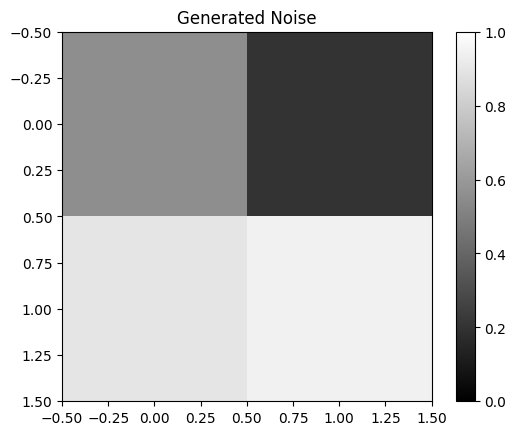

In [59]:
plt.imshow(test_noise.reshape(2, 2), cmap='gray', vmin=0, vmax=1)
plt.title(f"Generated Noise")
plt.colorbar()
plt.show()


In [60]:
test_real = generate_real_matrices(1)
test_real

tensor([[0.9149, 0.1802, 0.2789, 0.7047]])

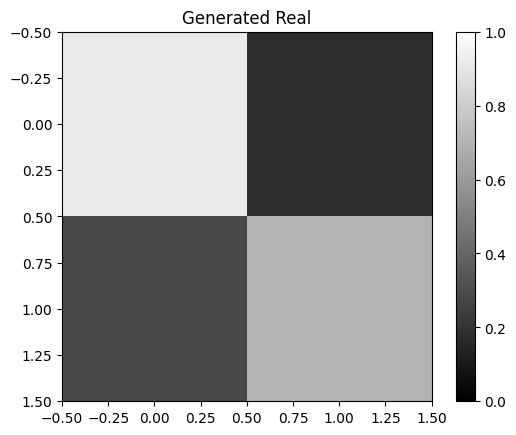

In [61]:
plt.imshow(test_real.reshape(2, 2), cmap='gray', vmin=0, vmax=1)
plt.title(f"Generated Real")
plt.colorbar()
plt.show()


In [104]:
dimens = 4
training_set_size = 1000
epochs = 16
alpha = 0.0001

In [105]:
generator = Generator(dimens)
discriminator = Discriminator(dimens)

In [106]:
loss_fn = nn.BCELoss()
gen_optim = optim.Adam(generator.parameters(), lr = alpha)
dis_optim = optim.Adam(discriminator.parameters(), lr = alpha)

In [107]:
real_mat_set = generate_real_matrices(training_set_size)
real_mat_set.size()

torch.Size([1000, 4])

In [108]:
train_loader = DataLoader(real_mat_set, batch_size = 1, shuffle = True, drop_last = True)

In [109]:
len(train_loader)

1000

In [110]:
for epoch in range(epochs):
  for i, (real_mat) in enumerate(train_loader):
    real_mat = real_mat.view(4)
    # print(real_mat.size())
    z = generate_noise()
    z = z.view(4)
    fake_mat = generator(z)

    # discriminator forward and backward for real matrix
    dis_optim.zero_grad()
    real_labels = torch.ones(1)
    output_real = discriminator(real_mat)
    loss_real = loss_fn(output_real, real_labels)
    loss_real.backward()

    # discriminator forward and backward for fake matrix
    fake_labels = torch.zeros(1)
    output_fake = discriminator(fake_mat.detach())
    # we used .detach here to use a copy tensor of the fake_waves
    # this is to prevent the gradients from flowing back into the generator
    loss_fake = loss_fn(output_fake, fake_labels)
    loss_fake.backward()

    # updating the discriminator
    dis_optim.step()

    # generator forward and backward
    gen_optim.zero_grad()
    output_generated = discriminator(fake_mat)
    gen_loss = loss_fn(output_generated, real_labels)
    # here we are getting the probability that the generated image is from the real data
    gen_loss.backward()

    # updating the generator
    gen_optim.step()

    if i%500 == 0:
      print(f"Epoch [{epoch}/{epochs}], Batch Step [{i}/{len(train_loader)}], "
            f"Discriminator Loss: {loss_real.item() + loss_fake.item()}, "
            f"Generator Loss: {gen_loss.item()}")


Epoch [0/16], Batch Step [0/1000], Discriminator Loss: 1.5701794922351837, Generator Loss: 0.3914722800254822
Epoch [0/16], Batch Step [500/1000], Discriminator Loss: 1.4568893909454346, Generator Loss: 0.45717430114746094
Epoch [1/16], Batch Step [0/1000], Discriminator Loss: 1.3675836622714996, Generator Loss: 0.516859233379364
Epoch [1/16], Batch Step [500/1000], Discriminator Loss: 1.3345567882061005, Generator Loss: 0.5660658478736877
Epoch [2/16], Batch Step [0/1000], Discriminator Loss: 1.2456184923648834, Generator Loss: 0.6375117897987366
Epoch [2/16], Batch Step [500/1000], Discriminator Loss: 1.2111778259277344, Generator Loss: 0.6711333394050598
Epoch [3/16], Batch Step [0/1000], Discriminator Loss: 1.2252320349216461, Generator Loss: 0.648837685585022
Epoch [3/16], Batch Step [500/1000], Discriminator Loss: 1.2409369945526123, Generator Loss: 0.6886890530586243
Epoch [4/16], Batch Step [0/1000], Discriminator Loss: 1.1519627571105957, Generator Loss: 0.715259313583374
Epoc

In [113]:
test_noise = generate_noise()
generated = generator(test_noise)
generated

tensor([0.9318, 0.1494, 0.0618, 0.9079], grad_fn=<SigmoidBackward0>)

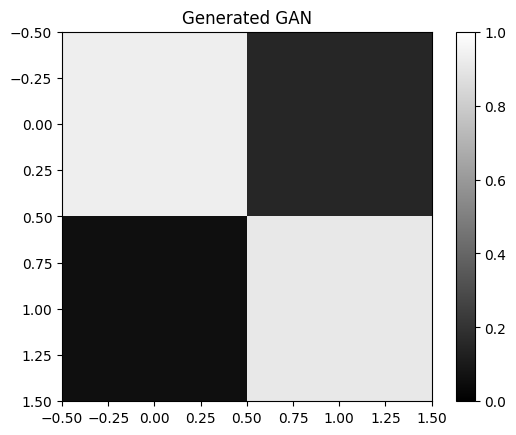

In [114]:
with torch.no_grad():
  plt.imshow(generated.reshape(2, 2), cmap='gray', vmin=0, vmax=1)
  plt.title(f"Generated GAN")
  plt.colorbar()
  plt.show()
